In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation

In [9]:
# Filter data to limit number of nodes to 10
node_max = 10
df = pd.read_csv('bicycle_network.csv')
df = df.loc[(df.node1 < node_max) & (df.node2 < node_max)]
df['scenic_score'] = df.drop(['node1', 'node2', 'distance'], axis=1).sum(axis=1) #+ 5 * df.drop(['node1', 'node2', 'distance'], axis=1).min(axis=1)
# df['scenic_score'] = df.scenic_beauty ** 3 + df.roughness + df.safety ** 2 + df.slope * 3

g = nx.Graph()
for node1 in range(node_max):
    for node2 in range(node_max):
        if node1 == node2:
            continue
        g.add_edge(node1,
                   node2,
                   distance=df.loc[(df.node1 == node1) & (df.node2 == node2), 'distance'].values[0],
                   scenic_score=df.loc[(df.node1 == node1) & (df.node2 == node2), 'scenic_score'].values[0])




In [10]:
# Define objectives
class BicycleRoutingProblem(ElementwiseProblem):
    def __init__(self, graph):
        super().__init__(
            n_var=node_max, n_obj=2, n_constr=0,
            xl=np.zeros(node_max), xu=np.ones(node_max) * (node_max - 1), type_var=int
        )
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        scenic_score = 0
        distance = 0
        x = np.floor(x).astype(int)
        for i in range(len(x) - 1):
            scenic_score += self.graph.get_edge_data(x[i], x[i+1])['scenic_score']
            distance += self.graph.get_edge_data(x[i], x[i+1])['distance']

        out['F'] = [distance, -scenic_score]

class FixStartPoint(Repair):
    def _do(self, problem, X, **kwargs):
        # Assuming we are always starting from node 0
        I = np.where(X == 0)[1]
        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])
        return X


problem = BicycleRoutingProblem(g)
algorithm = NSGA2(
    pop_size=1000,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=OrderCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True,
    repair=FixStartPoint()
)
termination = DefaultMultiObjectiveTermination(n_max_gen=500)

res = minimize(problem,
               algorithm,
               termination,
            #    seed=1,
               save_history=True,
               verbose=True)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      999 |      9 |             - |             -
     2 |     1099 |     10 |  0.0270270270 |         ideal
     3 |     1199 |     10 |  0.000000E+00 |             f
     4 |     1299 |     11 |  0.0453661698 |         ideal
     5 |     1399 |     10 |  0.0638297872 |         ideal
     6 |     1499 |     10 |  0.0156924039 |             f
     7 |     1599 |     11 |  0.0075142923 |             f
     8 |     1699 |     12 |  0.0246951220 |         ideal
     9 |     1799 |     12 |  0.0019563008 |             f
    10 |     1899 |     15 |  0.0175930811 |             f
    11 |     1999 |     16 |  0.0040742237 |             f
    12 |     2099 |     15 |  0.0048319709 |             f
    13 |     2199 |     16 |  0.0714285714 |         ideal
    14 |     2299 |     17 |  0.0014259458 |             f
    15 |     2399 |     16 |  0.0111426546 |             f
    16 |     2499 |     16 |  0.0039527695 |            

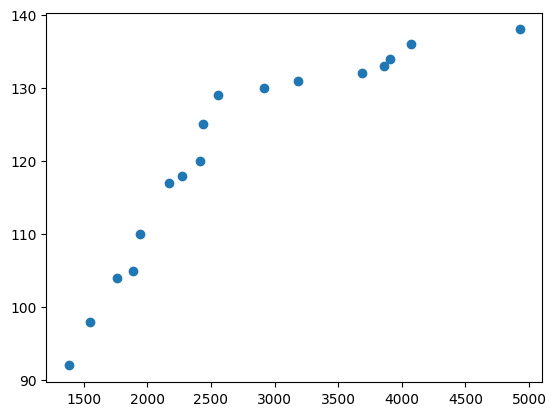

In [11]:
front = res.F.copy()
plt.scatter(front[:, 0], -front[:, 1])
plt.show()